In [1]:
using Oceananigans
using NCDatasets
using Printf
using CairoMakie
using Oceananigans.Fields
using Oceananigans.AbstractOperations: volume
using NaNStatistics

In [2]:
using TopographicHorizontalConvection: HorizontalConvectionSimulation

In [3]:
#function to find  χ same method used for turbulent and diffusive
function find_χ(ds)
    x = ds["xC"][4+1:end-4]; Nx = length(x);
    z = ds["zC"][4+1:end-4]; Nz = length(z);
    time = ds["time"][:];
    Δx = reshape(diff(ds["xF"])[4+1:end-4], Nx,1,1);
    Δz = reshape(diff(ds["zF"])[4+1:end-4], 1,1,Nz);
    ΔA = Δx; #flat in y -- 2 dimensional
    ΔV = ΔA.*Δz;
    χ = zeros(size(time,1));
    for n in 1:size(time, 1)
        χt = ds["chi"][4+1:end-4, 1, 4+1:end-4, n]
        wet = χt.!=0.
        χt[.!wet] .= NaN
        χ[n] = nansum(
            χt .*
            ΔV,
            dims=(1,2,3)
        )[1,1,1]
    end
    return χ
    
    
end

find_χ (generic function with 1 method)

In [19]:
#input for turbulent χ's
prefix = "/Users/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_Ra";
suffix = "_buoyancy.nc";

ds_array = [NCDataset(string(prefix, "100000.0", suffix)),
            NCDataset(string(prefix, "1.0e6", suffix)),
            NCDataset(string(prefix, "1.0e7", suffix))];
            #NCDataset(string(prefix, "1.0e8", suffix))];




χ_array = [find_χ(ds) for ds in ds_array];



In [20]:
#turbulent chi arrays below

χ_turb_1e5 = χ_array[1];
χ_turb_1e6 = χ_array[2];
χ_turb_1e7 = χ_array[3];
#χ_turb_1e8 = χ_array[4];

317-element Vector{Float64}:
   1.295268874031689
   0.4087690933336454
   0.4675629289767685
   0.38923178908629863
   0.5112419157356785
   0.4502043353260497
   0.3669863527801703
   0.4186772940585184
   0.35033887157121135
   0.3471644278045556
   ⋮
 201.7530745969309
 204.8809302589909
 204.27834500480313
 204.77471574236455
 208.20428118114023
 208.45467604911767
 213.3743022952707
 214.0605027706806
 218.63988141510998

In [21]:
#now the corresponding diffusive χ's
prefix_diff = "/Users/hfdrake/code/HorizontalConvection/output/diffusive_h0.6_Ra";
suffix_diff = "_buoyancy.nc";

ds_array_diff = [NCDataset(string(prefix_diff, "100000.0", suffix_diff)),
            NCDataset(string(prefix_diff, "1.0e6", suffix_diff)),
            NCDataset(string(prefix_diff, "1.0e7", suffix_diff))]
            #NCDataset(string(prefix_diff, "1.0e8", suffix_diff))];

χ_array_diff = [find_χ(ds) for ds in ds_array_diff];

In [22]:
χ_diff_1e5 = χ_array_diff[1];
χ_diff_1e6 = χ_array_diff[2];
χ_diff_1e7 = χ_array_diff[3];
#χ_diff_1e8 = χ_array_diff[4];

317-element Vector{Float64}:
 1.2952690295390377
 0.28461183283522284
 0.20245140304194703
 0.16573122177130736
 0.14377626239514724
 0.12876436848891035
 0.11766022550810999
 0.10900917690777984
 0.10201686800842359
 0.09620858302034696
 ⋮
 0.005236647038990982
 0.005229861133251907
 0.005223188473055339
 0.005216627161643917
 0.005210175334145377
 0.005203831157035034
 0.005197592827605928
 0.005191458573449258
 0.00518542665194315

In [25]:
Nusselt_1e5 = χ_turb_1e5 ./ χ_diff_1e5;
Nusselt_1e6 = χ_turb_1e6 ./ χ_diff_1e6;
Nusselt_1e7 = χ_turb_1e7 ./ χ_diff_1e7;
#Nusselt_1e8 = χ_turb_1e8 ./ χ_diff_1e8;


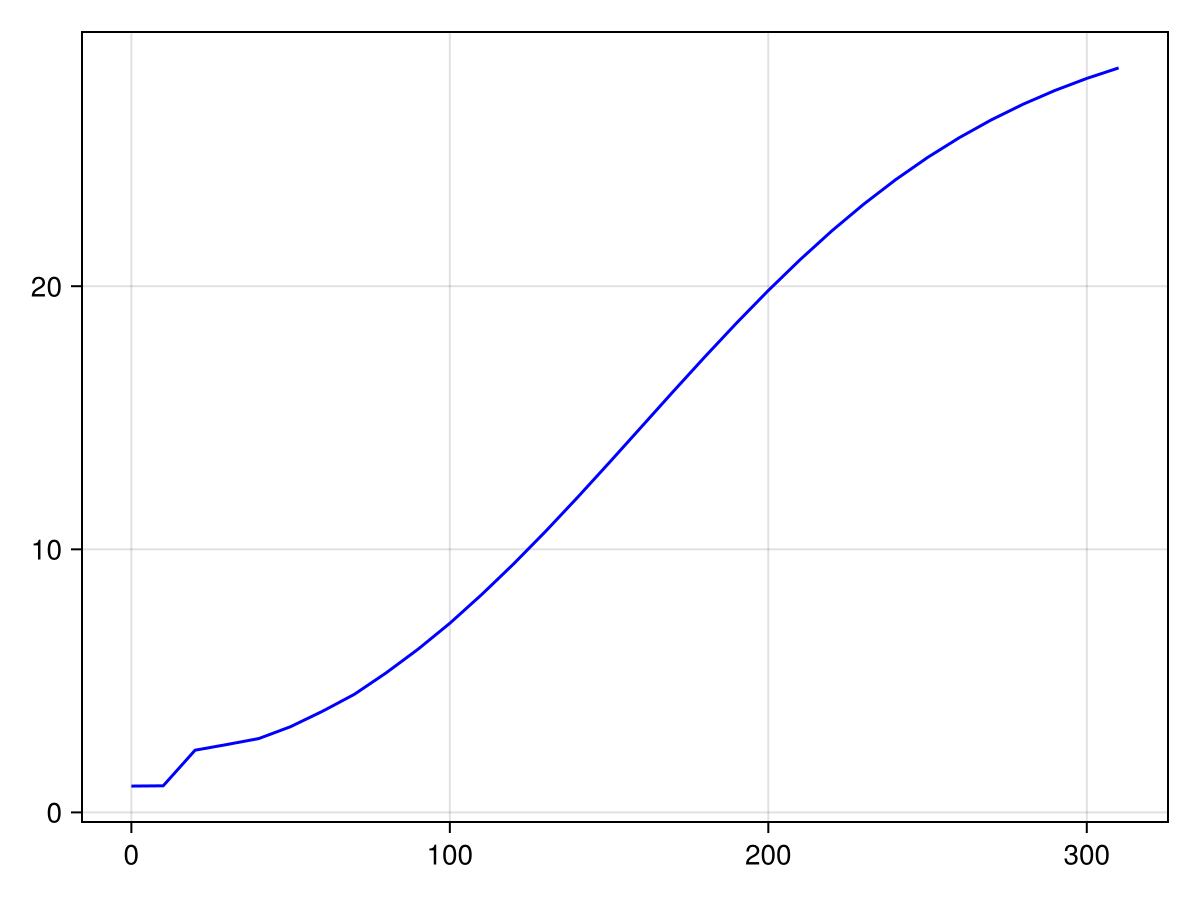

In [26]:
lines(ds_array[1]["time"][:], Nusselt_1e5, label="Ra = 1e5", color=:blue)

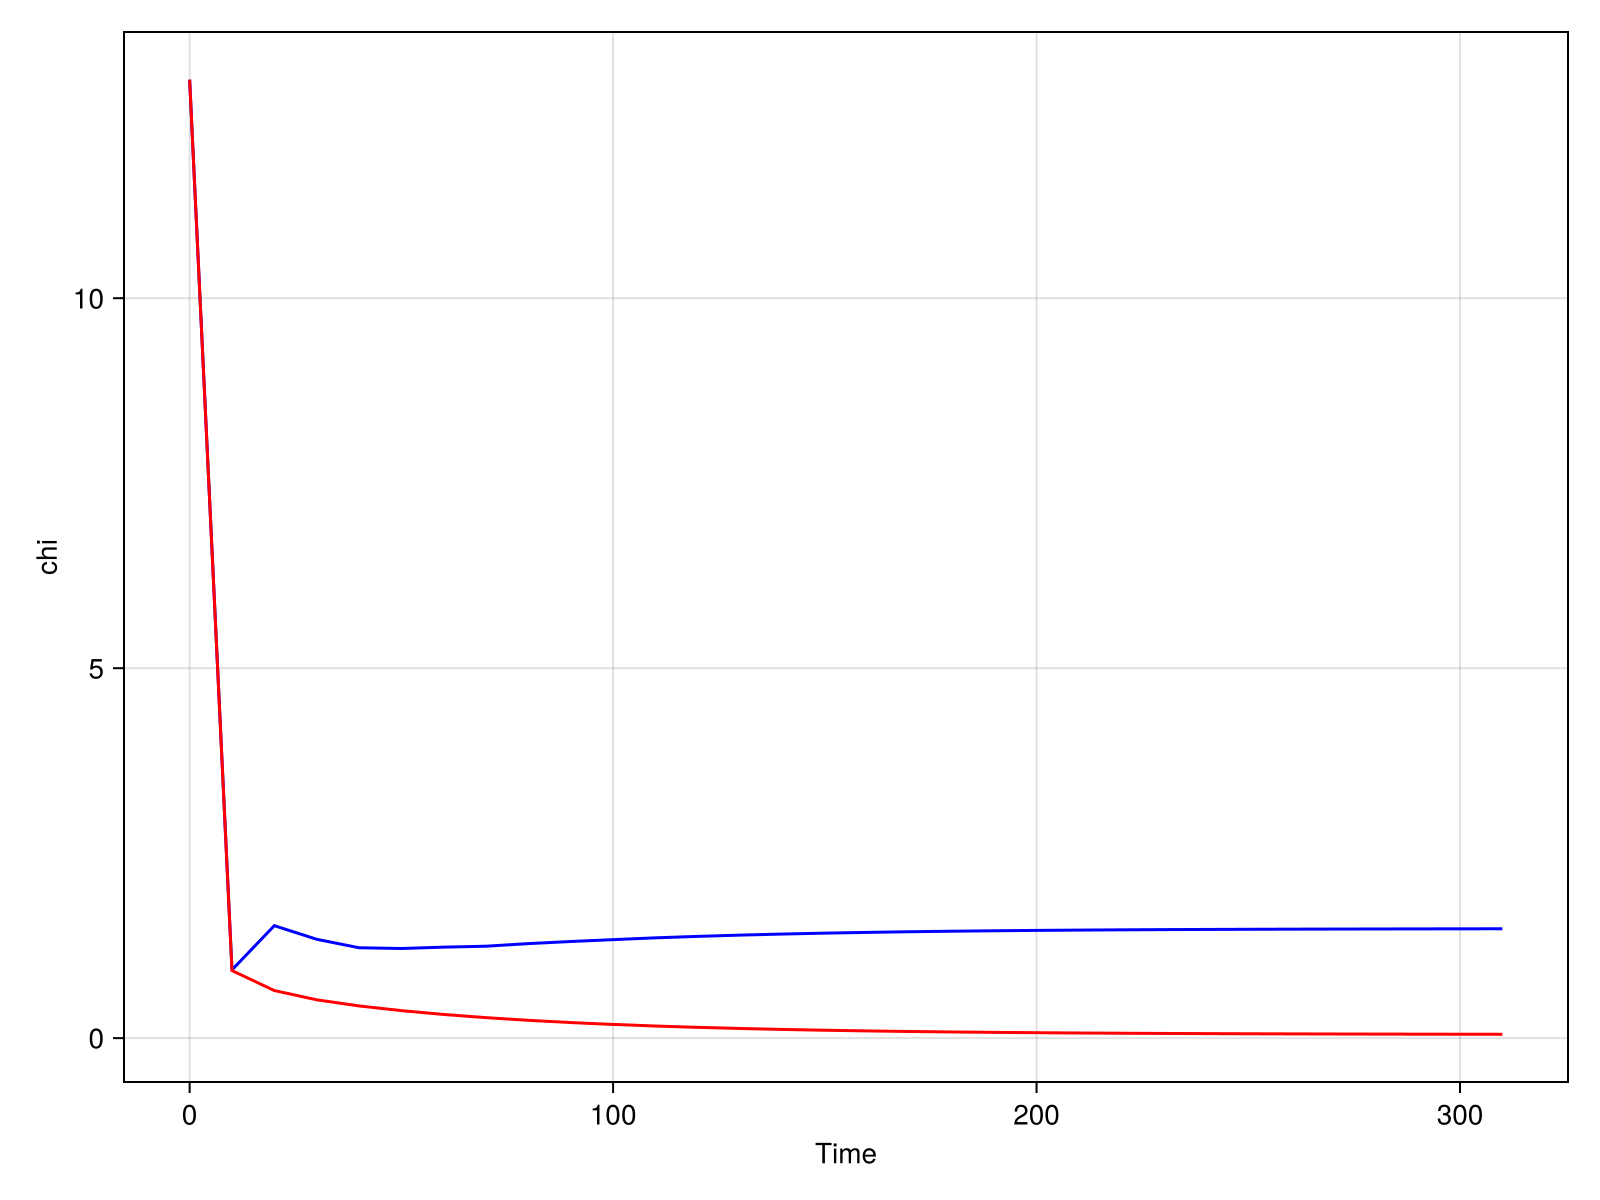

In [28]:
#turbulent versus diffusive chi for Ra=1e5
fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "chi")
lines!(ax, ds_array[1]["time"][:], χ_turb_1e5, label="Ra = 1e5", color=:blue)
lines!(ax, ds_array[1]["time"][:], χ_diff_1e5, label="Ra = 1e5", color=:red)
fig

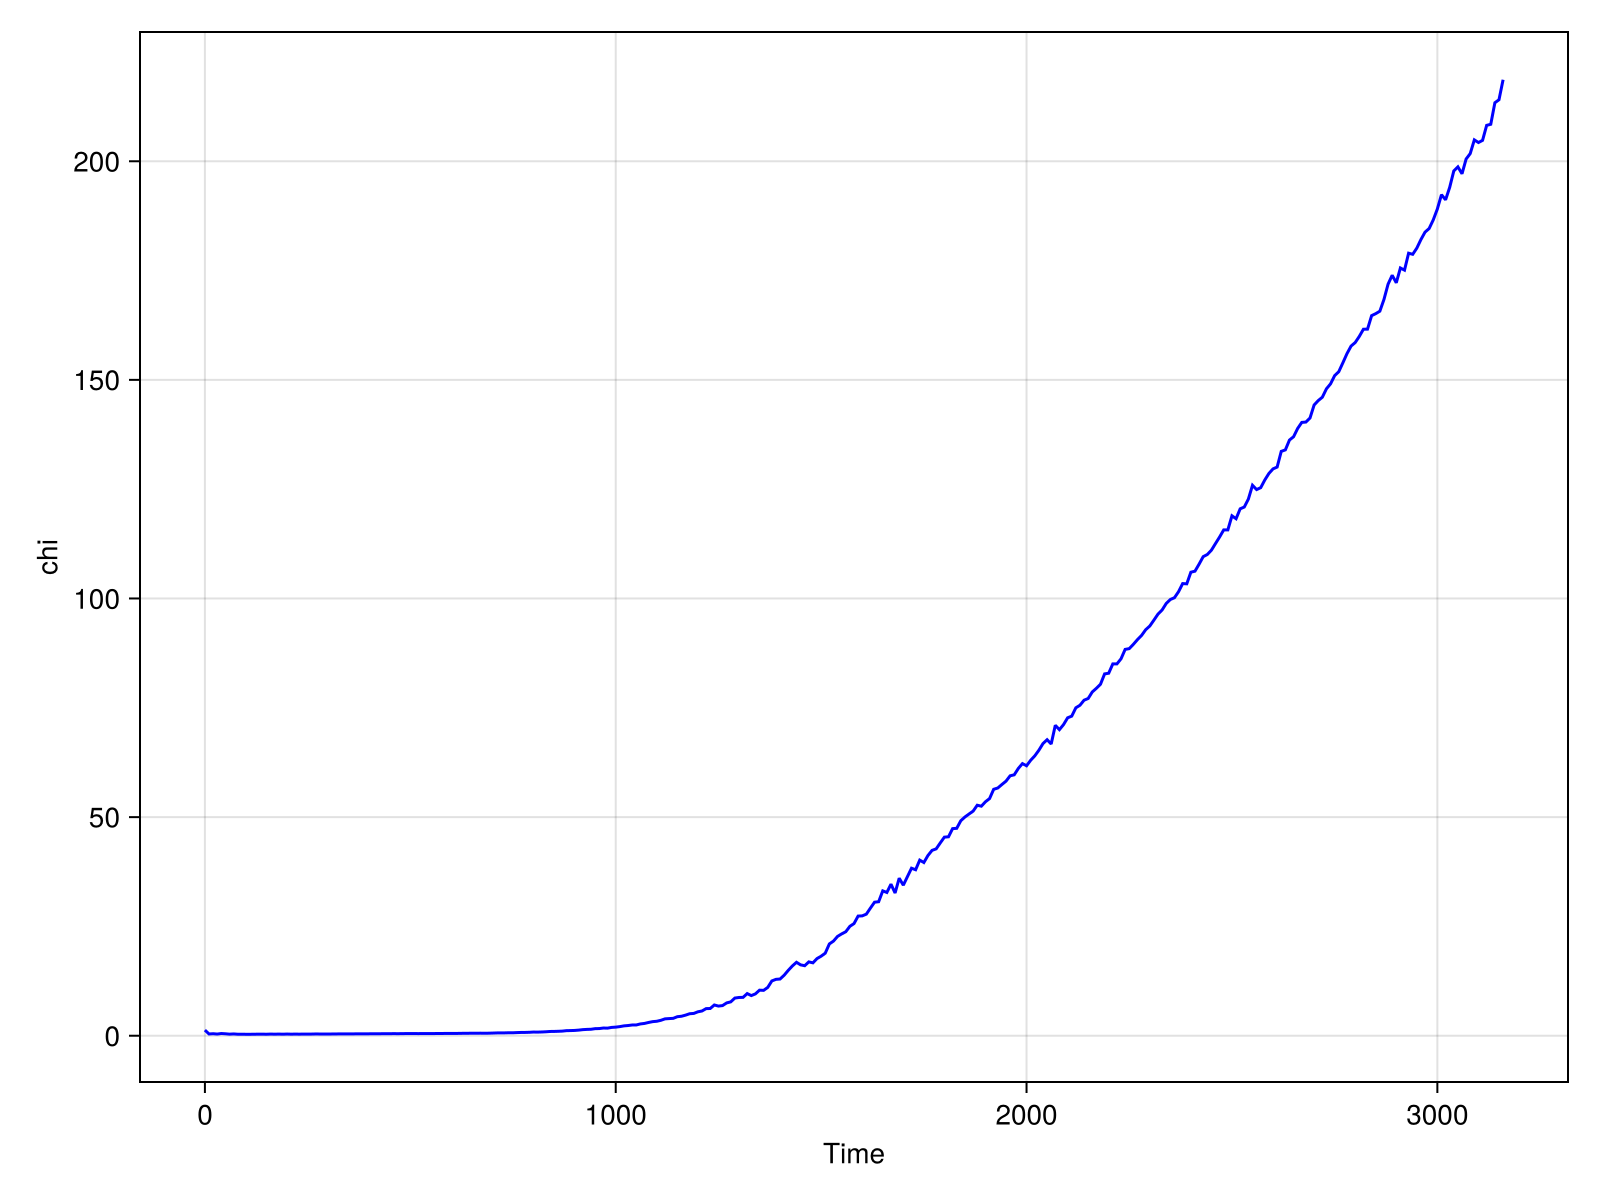

In [36]:
#turbulent versus diffusive chi for Ra=1e7
fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "chi")
lines!(ax, ds_array[3]["time"][:], χ_turb_1e7, label="Ra = 1e7", color=:blue)
lines!(ax, ds_array[3]["time"][:], χ_diff_1e7, label="Ra = 1e7", color=:red)
fig

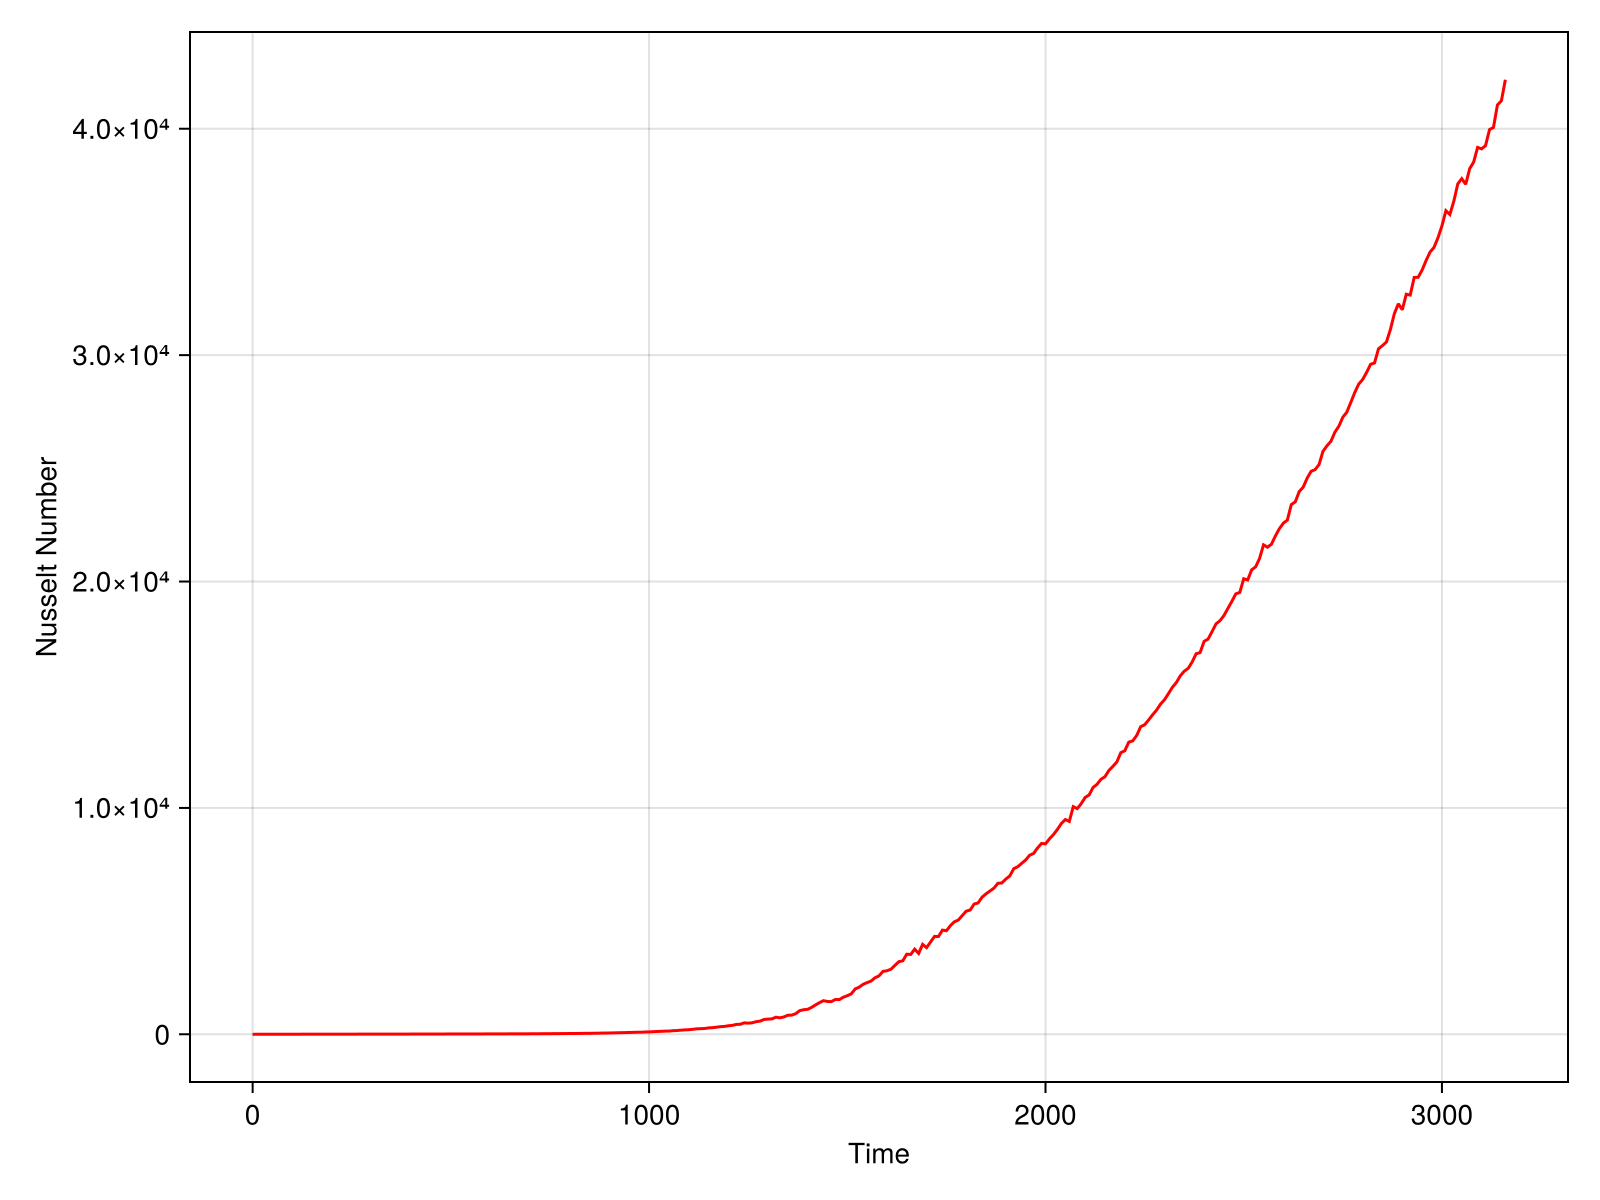

In [29]:
fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "Nusselt Number")
#lines!(ds_array[1]["time"][:], Nusselt_1e5, label="Ra = 1e5", color=:blue)
#lines!(ds_array[2]["time"][:], Nusselt_1e6, label="Ra = 1e6", color=:green)
lines!(ds_array[3]["time"][:], Nusselt_1e7, label="Ra = 1e7", color=:red)
#lines!(ds_array[4]["time"][:], Nusselt_1e8, label="Ra = 1e8", color=:purple)

fig

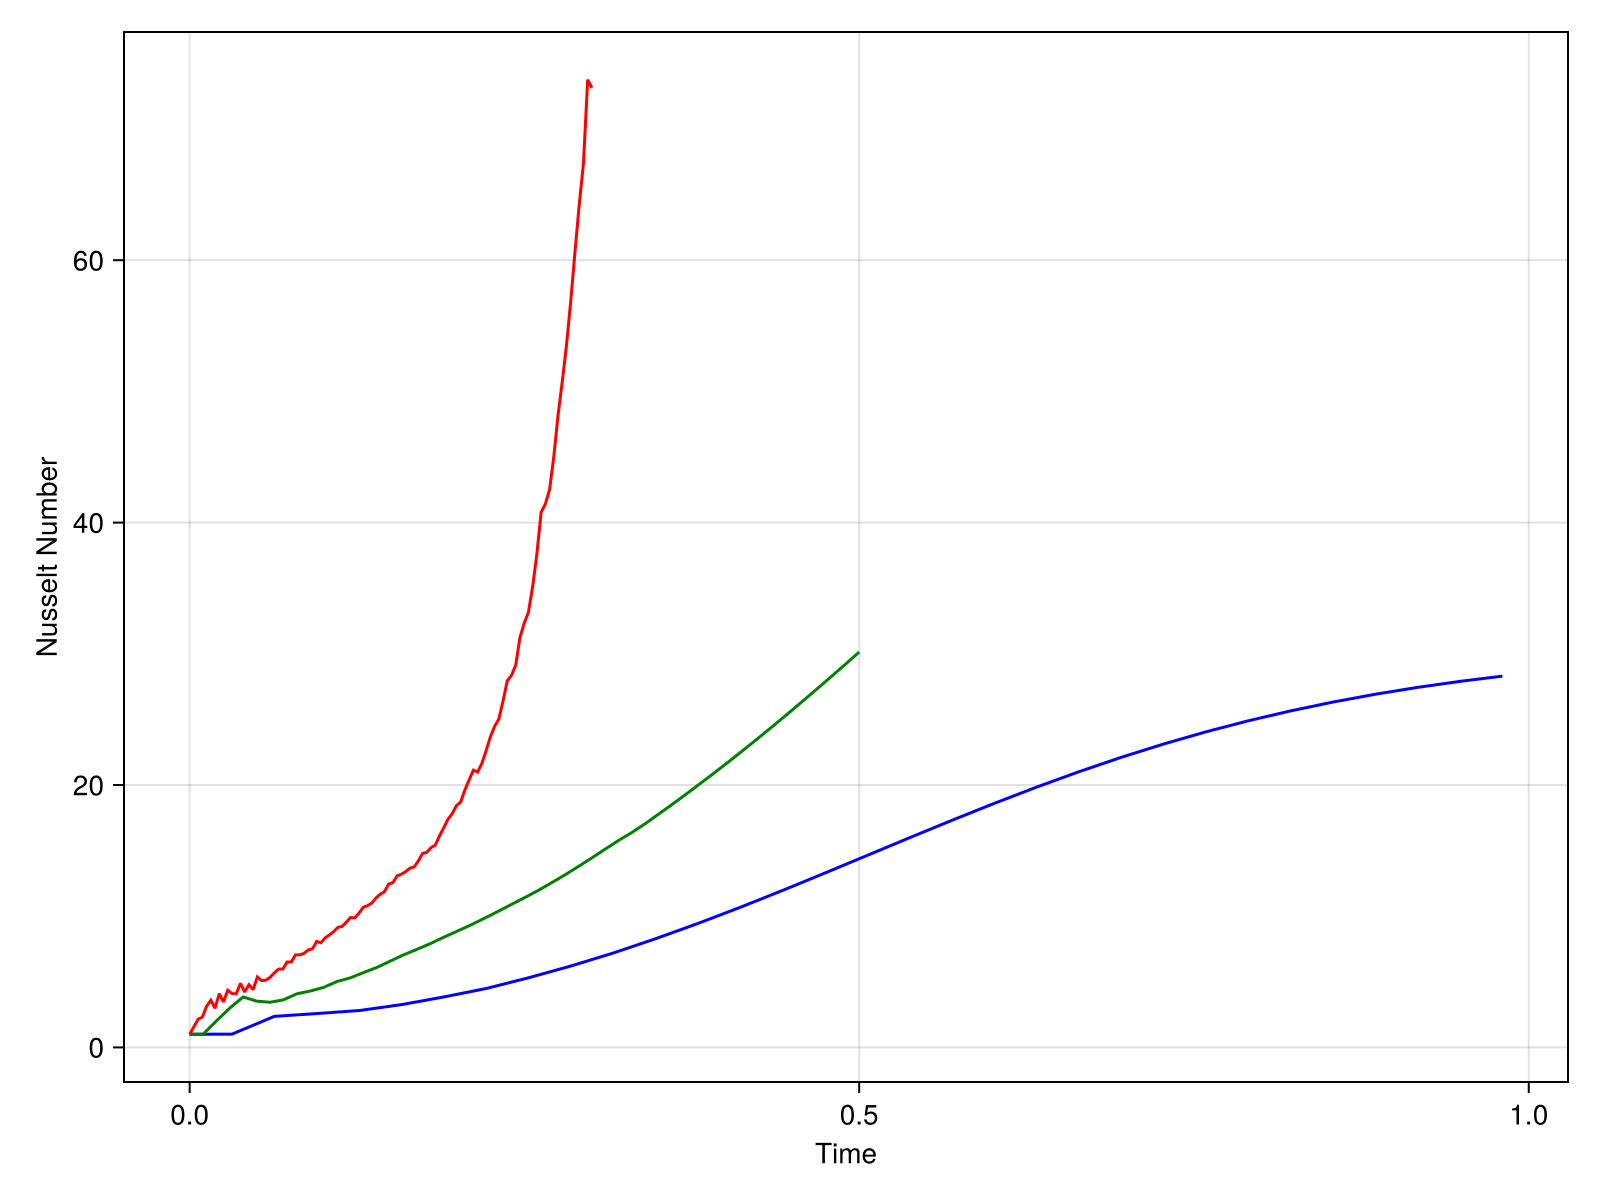

In [127]:
#normalize time arrays by multiplying by 1/sqrt(Ra) to compare the time scales of the simulations

time_1e5 = ds_array[1]["time"][:].*1/sqrt(1e5);
time_1e6 = ds_array[2]["time"][:].*1/sqrt(1e6);
time_1e7 = ds_array[3]["time"][:].*1/sqrt(1e7);
time_1e8 = ds_array[4]["time"][:].*1/sqrt(1e8);

times = [time_1e5, time_1e6, time_1e7, time_1e8];

#plotting the normalized time arrays
fig = Figure(resolution = (800, 600))
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "Nusselt Number")
lines!(time_1e5, Nusselt_1e5, label="Ra = 1e5", color=:blue)
lines!(time_1e6, Nusselt_1e6, label="Ra = 1e6", color=:green)
lines!(time_1e7, Nusselt_1e7, label="Ra = 1e7", color=:red)
#lines!(time_1e8, Nusselt_1e8, label="Ra = 1e8", color=:purple)
fig


In [85]:
#bottom buoyancy plots

#average of b(z=-h) over x from rocha improved bounds paper fig 2

b_bottom_1e5 = ds_array[1]["b"][4+1:end-4,1,4+1,:] #Ra = 1e5
b_bottom_1e6 = ds_array[2]["b"][4+1:end-4,1,4+1,:] #Ra = 1e6

using NaNStatistics
function buoyancy_bottom_avg(b_bottom)
    bottom_avg = zeros(size(b_bottom[1,:]));
    for n in 1:size(b_bottom,2)
        bb = b_bottom[:,n]
        wet = bb.!=0.
        bb[.!wet] .= NaN

        bottom_avg[n] = nanmean(bb, dims=1)[1,1]
    end
    return bottom_avg
end



#b_bottom_average = nanmean(b_bottom, dims=1)


buoyancy_bottom_avg (generic function with 1 method)

In [97]:
b_bottom_1e5 = ds_array[1]["b"][4+1:end-4,1,4+1,:]; #Ra = 1e5
b_bottom_avg_1e5 = buoyancy_bottom_avg(b_bottom_1e5);

b_bottom_1e6 = ds_array[2]["b"][4+1:end-4,1,4+1,:]; #Ra = 1e6
b_bottom_avg_1e6 = buoyancy_bottom_avg(b_bottom_1e6);

b_bottom_1e7 = ds_array[3]["b"][4+1:end-4,1,4+1,:]; #Ra = 1e7
b_bottom_avg_1e7 = buoyancy_bottom_avg(b_bottom_1e7);

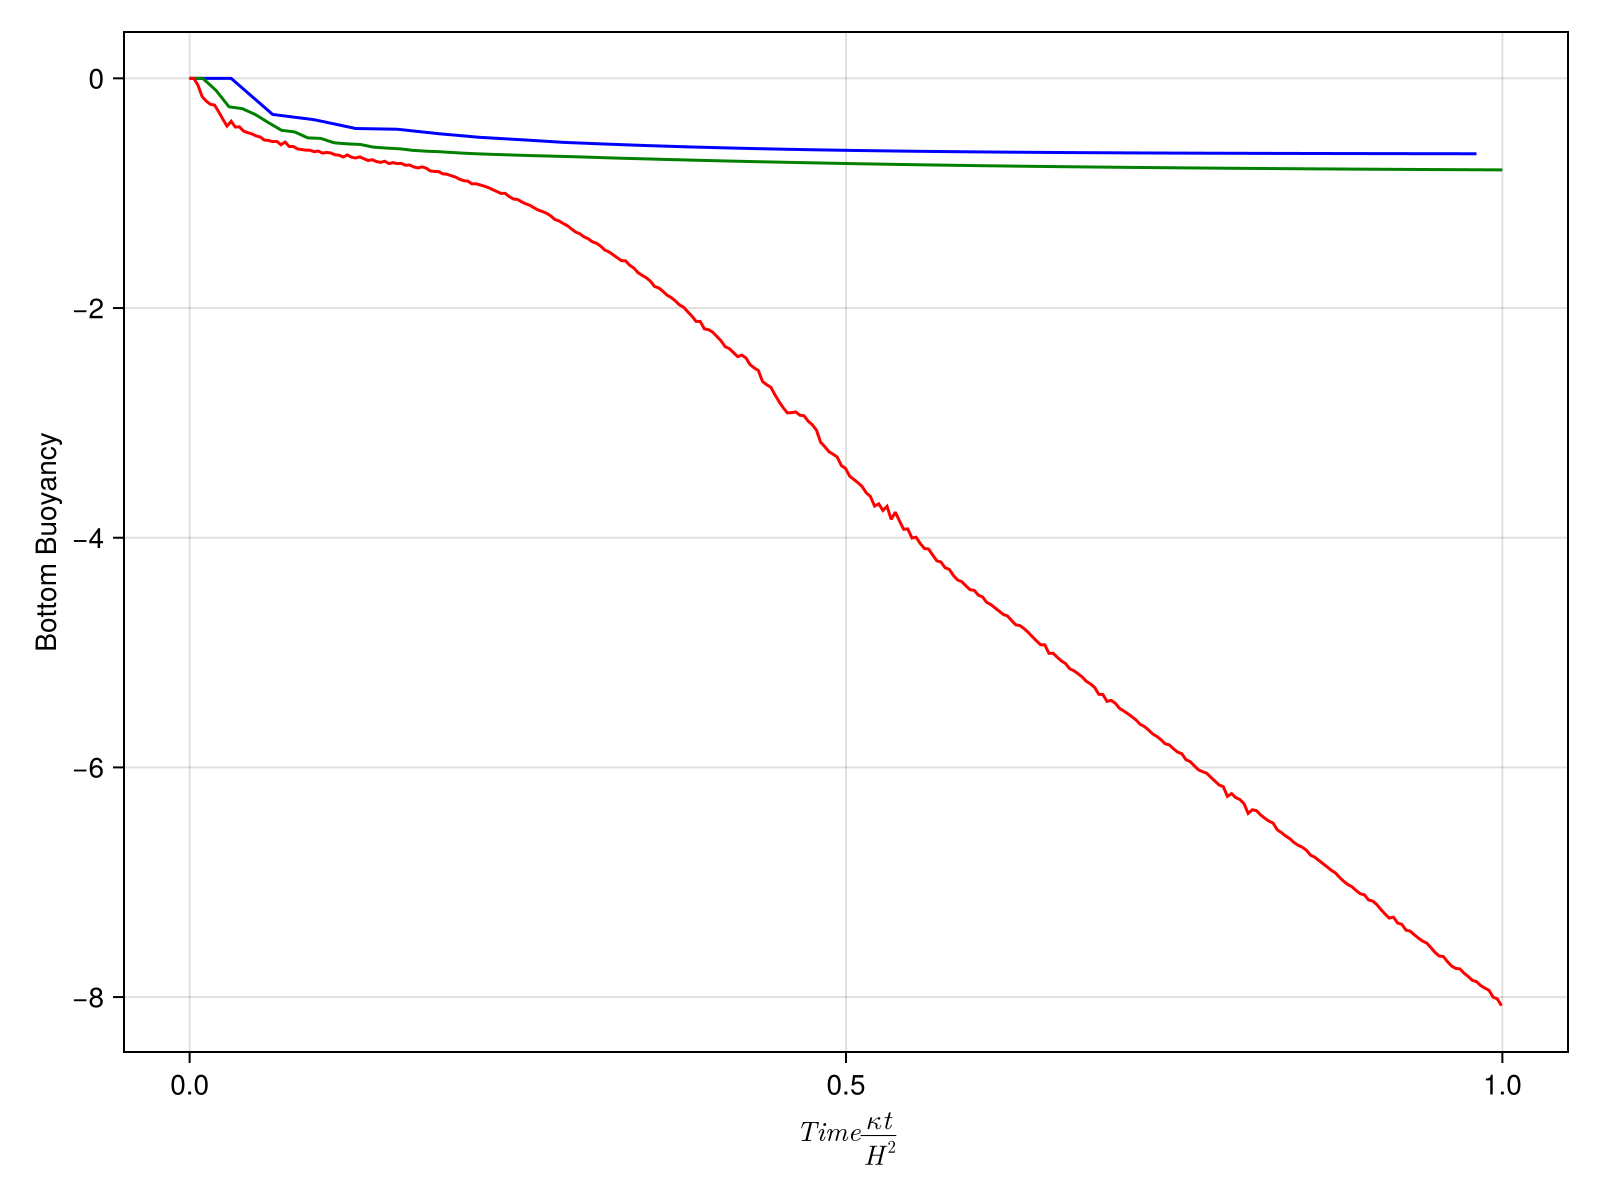

In [102]:
Pr = 1.0
b★ = 1.0
H = 1.0
#ν = sqrt(Pr * b★ * H^3 / Ra)
#κ = ν * Pr

ν_1e5 = sqrt(Pr * b★ * H^3 / 1e5)
ν_1e6 = sqrt(Pr * b★ * H^3 / 1e6)
ν_1e7 = sqrt(Pr * b★ * H^3 / 1e7)

κ_1e5 = ν_1e5 * Pr
κ_1e6 = ν_1e6 * Pr
κ_1e7 = ν_1e7 * Pr


normalized_time_1e5 = ds_array[1]["time"][:] .* (κ_1e5 / H^2)
normalized_time_1e6 = ds_array[2]["time"][:] .* (κ_1e6 / H^2)
normalized_time_1e7 = ds_array[3]["time"][:] .* (κ_1e7 / H^2)

fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], xlabel = L"Time \frac{κt}{H^2}", ylabel = "Bottom Buoyancy")
lines!(ax, normalized_time_1e5, b_bottom_avg_1e5, label="Ra = 1e5", color=:blue)
lines!(ax, normalized_time_1e6, b_bottom_avg_1e6, label="Ra = 1e6", color=:green)
lines!(ax, normalized_time_1e7, b_bottom_avg_1e7, label="Ra = 1e7", color=:red)
fig



In [111]:
#new analysis after hydrostatic_pressure_anomaly included

#input for turbulent χ's
turbprefix = "/Users/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_Ra";
diffprefix = "/Users/hfdrake/code/HorizontalConvection/output/diffusive_h0.6_Ra";
suffix = "_HydPresAnom_buoyancy.nc";

d = Dict(1e5 => "100000.0", 1e6 => "1.0e6", 1e7 => "1.0e7", 1e8 => "1.0e8")

turb_array = [NCDataset(string(turbprefix, d[Ra], suffix)) for (Ra,τ) in d]
diff_array = [NCDataset(string(diffprefix, d[Ra], suffix)) for (Ra,τ) in d]

In [121]:
#find χ for each dataset and use it to find Nusselt number arrays
χ_turb = [find_χ(ds) for ds in turb_array];

χ_diff = [find_χ(ds) for ds in diff_array];

Nusselt = [χ_turb[i] ./ χ_diff[i] for i in 1:4];

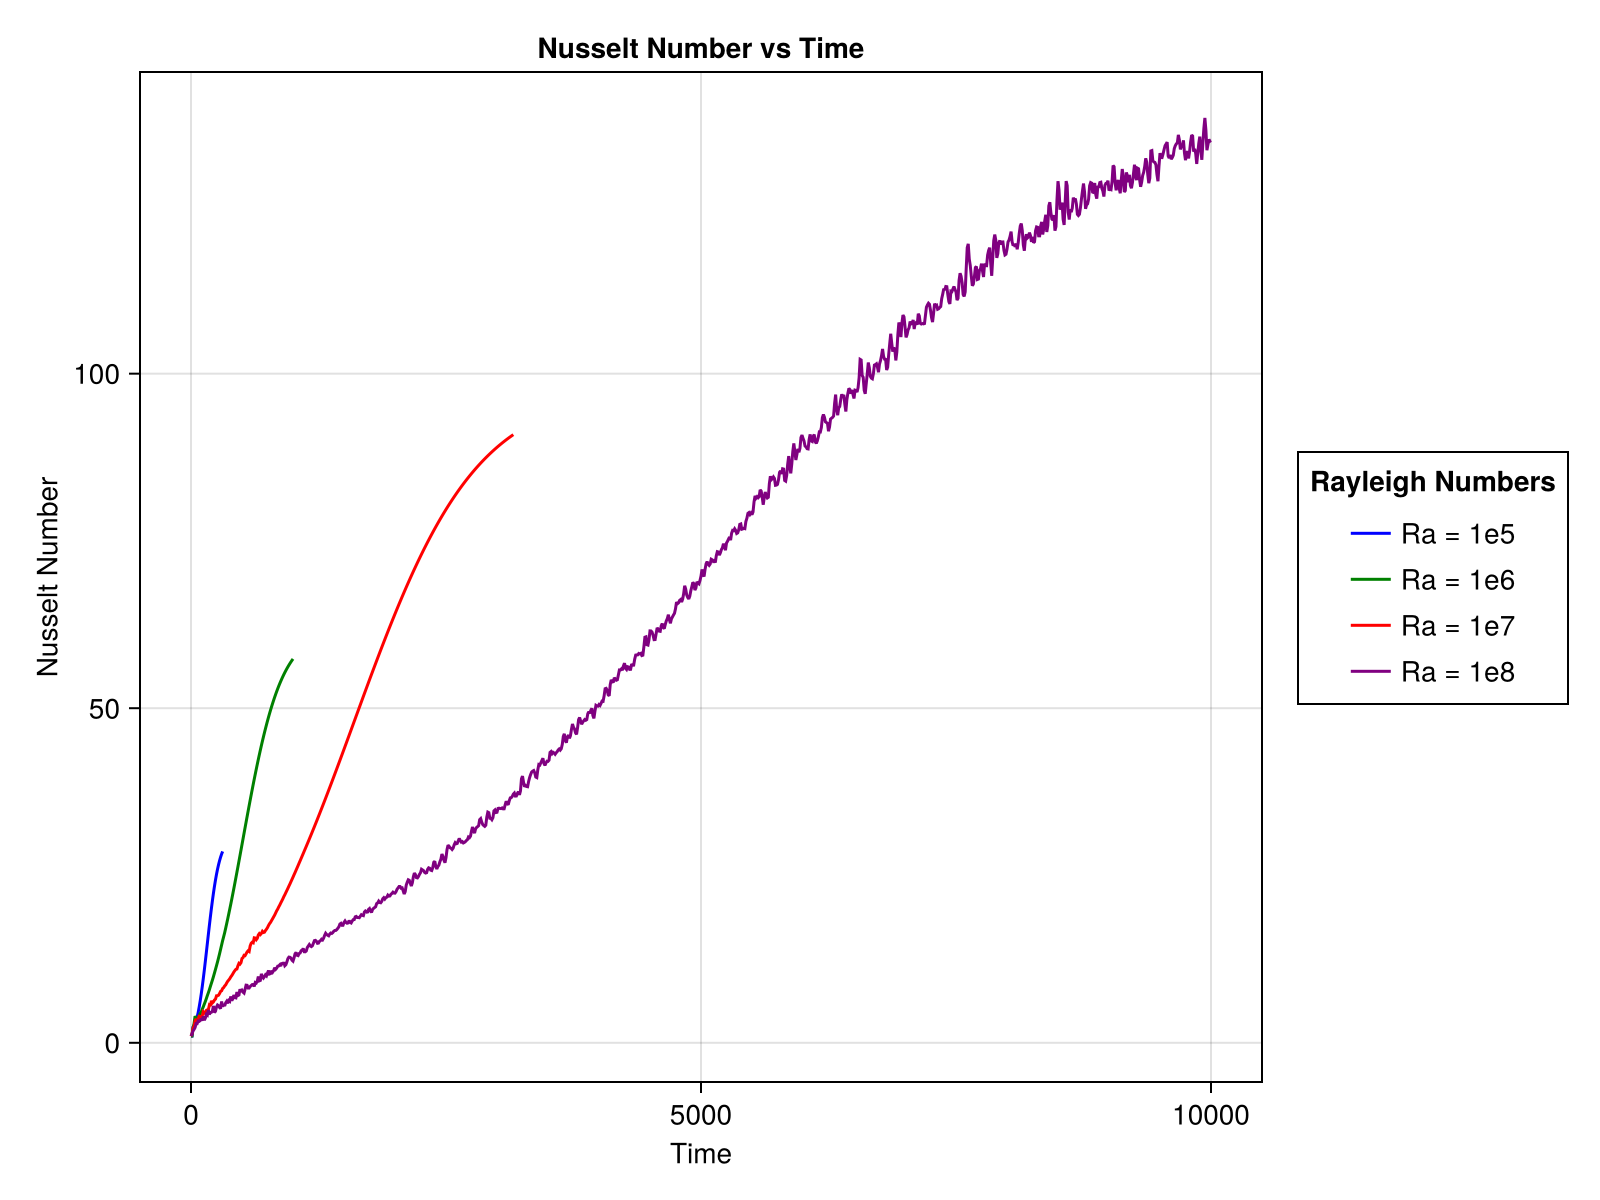

In [129]:
fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "Nusselt Number", title="Nusselt Number vs Time")
lines!(ax, turb_array[1]["time"][:], Nusselt[1], label="Ra = 1e5", color=:blue)
lines!(ax, turb_array[2]["time"][:], Nusselt[2], label="Ra = 1e6", color=:green)
lines!(ax, turb_array[3]["time"][:], Nusselt[3], label="Ra = 1e7", color=:red)
lines!(ax, turb_array[4]["time"][:], Nusselt[4], label="Ra = 1e8", color=:purple)
fig[1,2] = Legend(fig, ax, "Rayleigh Numbers")
fig

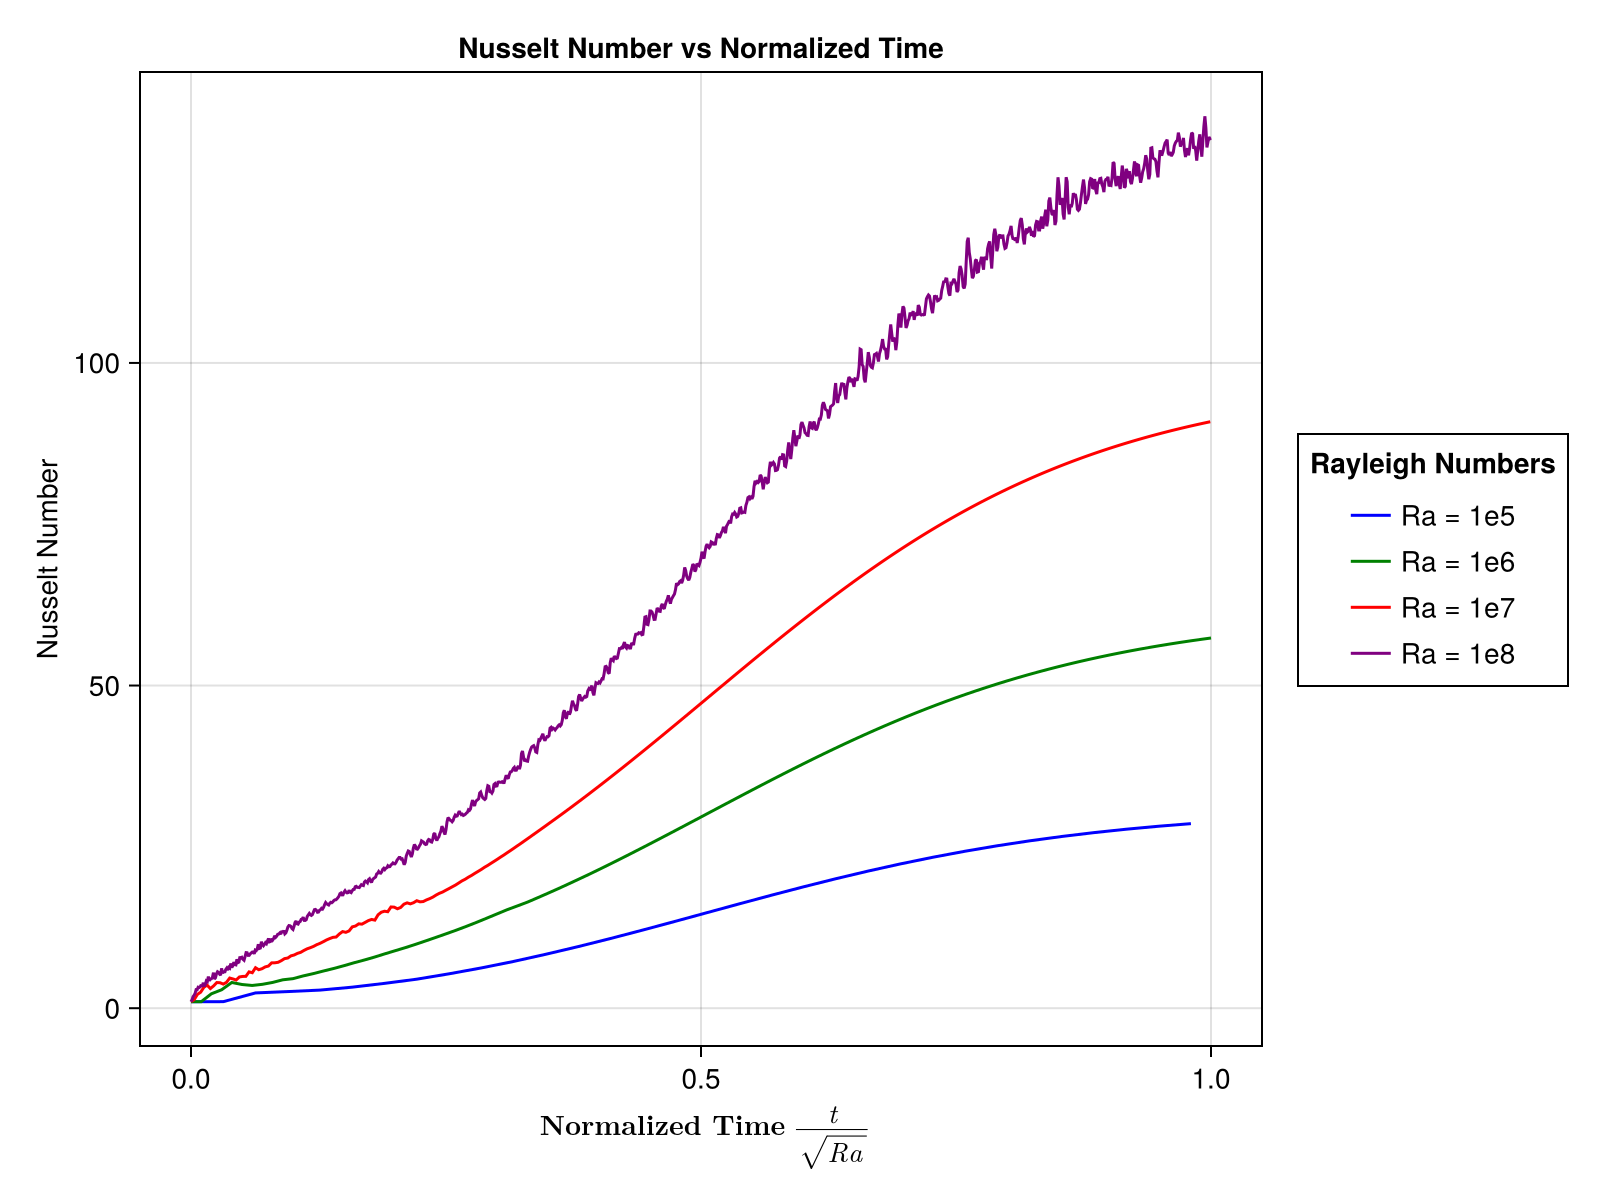

In [140]:
#Normalize time arrays by multiplying by 1/sqrt(Ra) to compare the time scales of the simulations

time_1e5 = turb_array[1]["time"][:].*1/sqrt(1e5);
time_1e6 = turb_array[2]["time"][:].*1/sqrt(1e6);
time_1e7 = turb_array[3]["time"][:].*1/sqrt(1e7);
time_1e8 = turb_array[4]["time"][:].*1/sqrt(1e8);

fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], xlabel = L"\textbf{Normalized Time } \frac{t}{\sqrt{Ra}}", ylabel = "Nusselt Number", title="Nusselt Number vs Normalized Time")
lines!(ax, time_1e5, Nusselt[1], label="Ra = 1e5", color=:blue)
lines!(ax, time_1e6, Nusselt[2], label="Ra = 1e6", color=:green)
lines!(ax, time_1e7, Nusselt[3], label="Ra = 1e7", color=:red)
lines!(ax, time_1e8, Nusselt[4], label="Ra = 1e8", color=:purple)
fig[1,2] = Legend(fig, ax, "Rayleigh Numbers")
fig

In [124]:
#buoyancy at the bottom of the domain for turbulent HC sims

b_bottom_1e5 = turb_array[1]["b"][4+1:end-4,1,4+1,:]; #Ra = 1e5
b_bottom_1e6 = turb_array[2]["b"][4+1:end-4,1,4+1,:]; #Ra = 1e6
b_bottom_1e7 = turb_array[3]["b"][4+1:end-4,1,4+1,:]; #Ra = 1e7
b_bottom_1e8 = turb_array[4]["b"][4+1:end-4,1,4+1,:]; #Ra = 1e8


using NaNStatistics
function buoyancy_bottom_avg(b_bottom)
    bottom_avg = zeros(size(b_bottom[1,:]));
    for n in 1:size(b_bottom,2)
        bb = b_bottom[:,n]
        wet = bb.!=0.
        bb[.!wet] .= NaN

        bottom_avg[n] = nanmean(bb, dims=1)[1,1]
    end
    return bottom_avg
end

b_bottom_avg_arrays = [buoyancy_bottom_avg(b_bottom) for b_bottom in [b_bottom_1e5, b_bottom_1e6, b_bottom_1e7, b_bottom_1e8]];

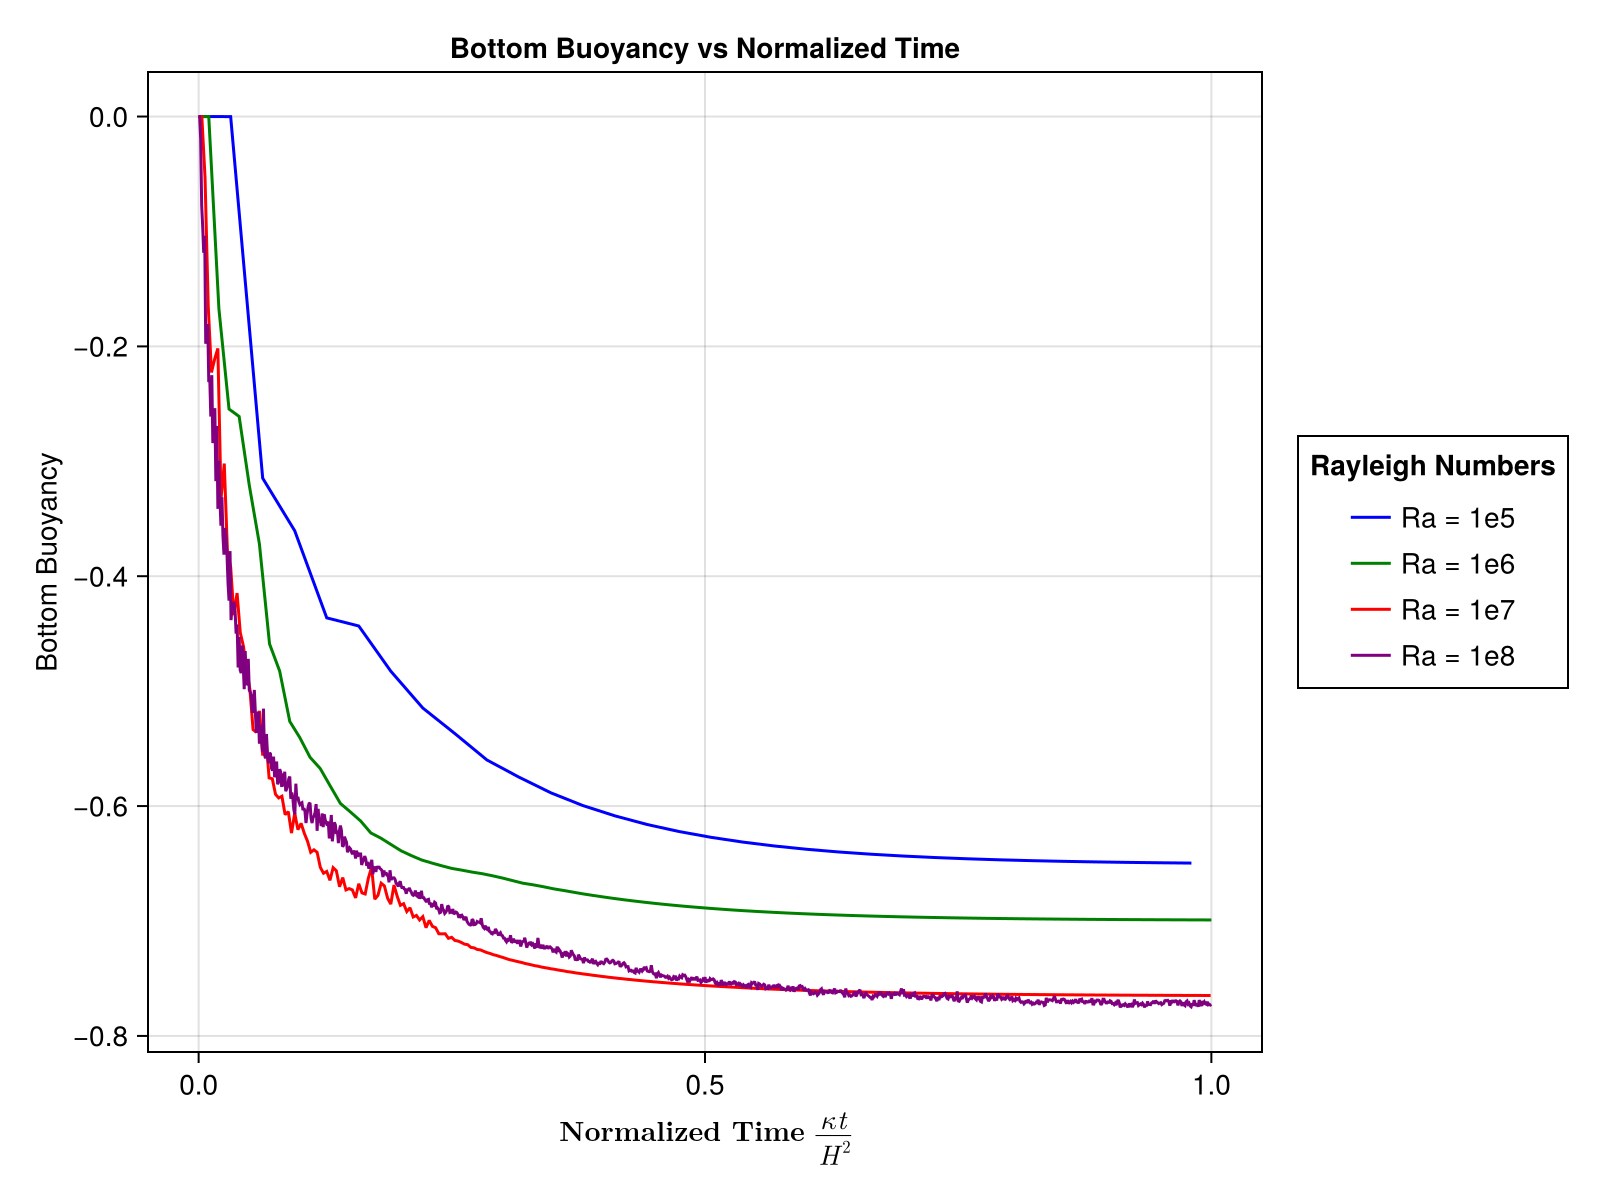

In [141]:
function normalized_time(Ra, time, H=1.0, Pr=1.0, b★=1.0)
    ν = sqrt(Pr * b★ * H^3 / Ra)
    κ = ν * Pr
    return time .* (κ / H^2)
end

normalized_times = [normalized_time(1e5, turb_array[1]["time"][:]),
                    normalized_time(1e6, turb_array[2]["time"][:]),
                    normalized_time(1e7, turb_array[3]["time"][:]),
                    normalized_time(1e8, turb_array[4]["time"][:])];

fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], xlabel = L"\textbf{Normalized Time } \frac{κt}{H^2}", ylabel = "Bottom Buoyancy", title = "Bottom Buoyancy vs Normalized Time")
lines!(ax, normalized_times[1], b_bottom_avg_arrays[1], label="Ra = 1e5", color=:blue)
lines!(ax, normalized_times[2], b_bottom_avg_arrays[2], label="Ra = 1e6", color=:green)
lines!(ax, normalized_times[3], b_bottom_avg_arrays[3], label="Ra = 1e7", color=:red)
lines!(ax, normalized_times[4], b_bottom_avg_arrays[4], label="Ra = 1e8", color=:purple)
fig[1,2] = Legend(fig, ax, "Rayleigh Numbers")
fig


In [152]:
#oceanostics diagnostics analysis

d = NCDataset("/Users/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_Ra100000.0_HydPresAnom_oceanostics.nc")

ε_1e5 = d["ε"][4+1:end-4,1,4+1:end-4,:];

Pr = 1.0;
b★ = 1.0;
H = 1.0;
Ra = 1e5;

ν = sqrt(Pr * b★ * H^3 / Ra);


In [186]:
#function to find  ε same method used for χ
function find_ε(ds)
    x = ds["xC"][4+1:end-4]; Nx = length(x);
    z = ds["zC"][4+1:end-4]; Nz = length(z);
    time = ds["time"][:];
    Δx = reshape(diff(ds["xF"])[4+1:end-4], Nx,1,1);
    Δz = reshape(diff(ds["zF"])[4+1:end-4], 1,1,Nz);
    ΔA = Δx; #flat in y -- 2 dimensional
    ΔV = ΔA.*Δz;
    ε = zeros(size(time,1));
    for n in 1:size(time, 1)
       εt = ds["ε"][4+1:end-4, 1, 4+1:end-4, n]
        wet =εt.!=0.
       εt[.!wet] .= NaN
        ε[n] = nansum(
           εt .*
            ΔV,
            dims=(1,2,3)
        )[1,1,1]
    end
    return ε
    
    
end

ε_1e5_avg = find_ε(d)

32-element Vector{Float64}:
 0.0
 0.06699272874746687
 0.958540915298667
 1.281202304080707
 1.0753463072330849
 0.9985744523377285
 0.9300744418545022
 0.838353180364851
 0.7880390623771198
 0.7329361494733703
 ⋮
 0.5353371364834588
 0.5333546229050038
 0.5317312403471044
 0.5304002961657628
 0.5293084538743154
 0.5284123318829939
 0.5276764727867663
 0.5270720076387553
 0.5265753479263144

In [200]:
z = d["zC"][4+1:end-4];
Nz = length(z);

Δz = reshape(diff(d["zF"])[4+1:end-4], 1,1,Nz);

#kolmogorov length scale 

λk =(ν^3 ./ ε_1e5_avg).^0.25



32-element Vector{Float64}:
 Inf
  0.026211572914338545
  0.013477127472577247
  0.012534169755801404
  0.013095223437535525
  0.01333997105638457
  0.013579087050631166
  0.01393616391981168
  0.014153474396253012
  0.014412305668481486
  ⋮
  0.015589893813355113
  0.01560436082392017
  0.01561625729289067
  0.015626044635356672
  0.0156340966486131
  0.015640720811238094
  0.015646170813924002
  0.01565065478394387
  0.015654343858049393

In [196]:
for i in 1:length(Nz)
    if Δz[i] < λk[i]
        println("Kolmogorov length scale is resolved")
    elseif Δz[i] > λk[i]
        println("Kolmogorov length scale is not resolved")
    end
end

Kolmogorov length scale is resolved
